In [7]:
import time
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from torch.optim import AdamW
from accelerate import Accelerator

In [8]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        norm = x.norm(2, dim=-1, keepdim=True)
        return x * self.weight / (norm / (x.shape[-1] ** 0.5) + self.eps)

def replace_layernorm_with_rmsnorm(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.LayerNorm):
            parent_name = name.rsplit('.', 1)[0]
            parent = dict(model.named_modules()).get(parent_name, model)
            setattr(parent, name.split('.')[-1], RMSNorm(module.normalized_shape[0], eps=module.eps))


In [9]:
def prepare_dataset():
    dataset = load_dataset("fancyzhx/dbpedia_14")
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    def tokenize(example):
        return tokenizer(example["content"], truncation=True, padding="max_length", max_length=128)

    encoded = dataset.map(tokenize, batched=True)
    encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    train_dataset = encoded["train"].shuffle(seed=42).select(range(5000))
    test_dataset = encoded["test"].shuffle(seed=42).select(range(1000))
    return train_dataset, test_dataset



In [10]:
def train_epoch(model, loader, criterion, optimizer, device, accelerator):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in loader:
        input_ids, attention_mask, labels = [batch[k].to(device) for k in ["input_ids", "attention_mask", "label"]]
        optimizer.zero_grad()
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(output.logits, labels)
        accelerator.backward(loss)
        optimizer.step()
        total_loss += loss.item()
        correct += (output.logits.argmax(1) == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(loader), correct / total

In [11]:
def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    start = time.time()
    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask, labels = [batch[k].to(device) for k in ["input_ids", "attention_mask", "label"]]
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = output.logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total, time.time() - start

In [13]:
def extract_cls_embeddings(model, loader, device, limit=500):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            output = model.distilbert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
            cls_vec = output[:, 0, :]  # CLS token: first token
            embeddings.append(cls_vec)
            if len(embeddings) * cls_vec.size(0) >= limit:
                break
    return torch.cat(embeddings, dim=0)[:limit]


In [14]:
def compare_and_plot(baseline_vecs, fp16_vecs):
    from torch.nn.functional import cosine_similarity
    import matplotlib.pyplot as plt

    cos_sim = cosine_similarity(baseline_vecs, fp16_vecs, dim=1)
    l2_dist = (baseline_vecs - fp16_vecs).norm(p=2, dim=1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(cos_sim.cpu().numpy(), bins=50, color='blue')
    plt.title("Cosine Similarity (Baseline vs FP16 RMSNorm)")
    plt.xlabel("Similarity"); plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    plt.hist(l2_dist.cpu().numpy(), bins=50, color='red')
    plt.title("L2 Distance (Baseline vs FP16 RMSNorm)")
    plt.xlabel("Distance"); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In [12]:
precision = "fp16"
train_data, test_data = prepare_dataset()
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=14)
replace_layernorm_with_rmsnorm(model)
accelerator = Accelerator(mixed_precision="fp16")
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)
test_loader = accelerator.prepare(test_loader)
NUM_EPOCHS = 10
epoch_losses = []
epoch_accuracies = []
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, accelerator.device, accelerator)
    epoch_losses.append(train_loss)
    epoch_accuracies.append(train_acc)
    print(f"Epoch {epoch+1}: loss = {train_loss:.4f}, acc = {train_acc:.4f}")
train_time = time.time() - start_time
train_mem = torch.cuda.max_memory_allocated() / 1e6
test_acc, test_time = evaluate(model, test_loader, accelerator.device)
result = {
    "precision": precision,
    "epoch_loss": epoch_losses,
    "epoch_acc": epoch_accuracies,
    "train_time": train_time,
    "train_mem": train_mem,
    "test_acc": test_acc,
    "test_time": test_time
}
with open("results_fp16.json", "w") as f:
    json.dump(result, f, indent=2)
print(json.dumps(result, indent=2))


Map: 100%|██████████| 70000/70000 [00:06<00:00, 10926.78 examples/s]
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: loss = 1.3695, acc = 0.6142
Epoch 2: loss = 0.3195, acc = 0.9134
Epoch 3: loss = 0.1787, acc = 0.9522
Epoch 4: loss = 0.1304, acc = 0.9650
Epoch 5: loss = 0.0804, acc = 0.9800
Epoch 6: loss = 0.0709, acc = 0.9808
Epoch 7: loss = 0.0550, acc = 0.9868
Epoch 8: loss = 0.0410, acc = 0.9888
Epoch 9: loss = 0.0349, acc = 0.9900
Epoch 10: loss = 0.0333, acc = 0.9914
{
  "precision": "fp16",
  "epoch_loss": [
    1.3695249313744493,
    0.319537323337203,
    0.1786504874285608,
    0.130377870773117,
    0.0804356687818282,
    0.0708730690829908,
    0.05500384124543387,
    0.040986854846354205,
    0.034859879524818956,
    0.0332666346260284
  ],
  "epoch_acc": [
    0.6142,
    0.9134,
    0.9522,
    0.965,
    0.98,
    0.9808,
    0.9868,
    0.9888,
    0.99,
    0.9914
  ],
  "train_time": 211.4695782661438,
  "train_mem": 1461.000192,
  "test_acc": 0.963,
  "test_time": 1.1926441192626953
}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


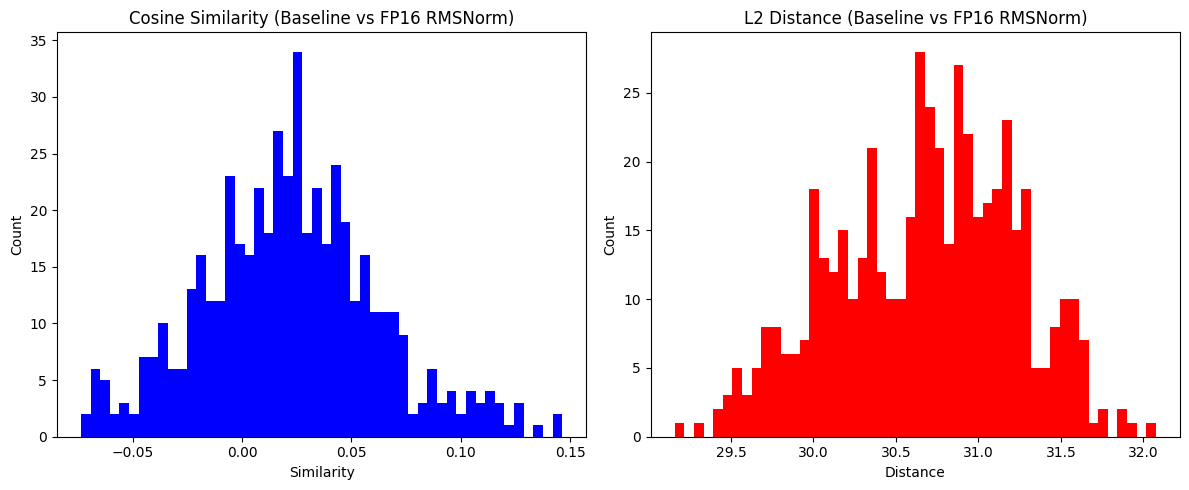

In [15]:
# Load baseline model (with LayerNorm)
baseline = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=14).to("cuda").eval()

# Prepare test_loader without accelerator
test_loader_cpu = DataLoader(test_data, batch_size=16)

# Extract vectors
baseline_vecs = extract_cls_embeddings(baseline, test_loader_cpu, device="cuda")
fp16_vecs     = extract_cls_embeddings(model, test_loader, device=accelerator.device)

# Plot
compare_and_plot(baseline_vecs, fp16_vecs)
